In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from dltools.callback import AvgStatsCallback, sched_lin, sched_cos, Recorder, AvgStatsCallback
from dltools.callback import ParamScheduler, combine_scheds, Callback, LearningrateFinder, DeviceCallback
from dltools.databunch import DataBunch
from dltools.functions import create_learner, get_dls, get_model, get_model_func, listify, normalize_to, get_data
from dltools.functions import get_learn_run
from dltools.layer import Lambda, flatten
from dltools.metrics import accuracy
from dltools.runner import Runner
from torch.utils.data import TensorDataset
import torch.nn.functional as F
import torch

ImportError: cannot import name 'TrainEvalCallback'

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
device

device(type='cuda')

In [4]:
from functools import partial

In [5]:
# !type fastaimanual.py

In [6]:
# changes rounding apparently
torch.set_num_threads(2)

In [7]:
x_train, y_train, x_valid, y_valid = get_data()
x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = TensorDataset(x_train, y_train), TensorDataset(x_valid, y_valid)

In [8]:
x_train.mean(), x_train.std(), x_valid.mean(), x_valid.std()

(tensor(3.0614e-05), tensor(1.), tensor(-0.0058), tensor(0.9924))

In [9]:
nh, bs = 50, 512
c = y_train.max().item()+1
loss_func = F.cross_entropy
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [ ]:
learn = create_learner(get_model, loss_func, data)

In [ ]:
run = Runner(cb_funcs = [LearningrateFinder, Recorder])

In [ ]:
run.fit(2, learn)

In [ ]:
run.recorder.plot(skip_last=5)

In [ ]:
run.recorder.plot_lr()

### Basic callbacks from before

In [10]:
def mnist_resize(x):
    return x.view(-1, 1, 28, 28)

In [11]:
from torch import nn

In [12]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding = 2, stride = 2), nn.ReLU(), # 14
        nn.Conv2d( 8,16, 3, padding = 1, stride = 2), nn.ReLU(), #  7
        nn.Conv2d(16,32, 3, padding = 1, stride = 2), nn.ReLU(), #  4
        nn.Conv2d(32,32, 3, padding = 1, stride = 2), nn.ReLU(), #  2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32, data.c)
    )

In [13]:
model = get_cnn_model(data)

In [14]:
cbfs = [DeviceCallback, Recorder, partial(AvgStatsCallback, accuracy)]

In [15]:
from torch import optim
from dltools.learner import Learner

In [16]:
opt = optim.SGD(model.parameters(), lr = 0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs = cbfs)

self.device: cuda


In [ ]:
%time run.fit(1, learn)

### Refactor

In [17]:
def conv2d(ni, kf, ks=3, stride=2):
    return nn.Sequential(nn.Conv2d(ni, kf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [18]:
class BatchTransformXCallback(Callback):
    _order = 2
    def __init__(self, tfm):
        self.tfm = tfm
    
    def begin_batch(self):
        self.run.xb = self.tfm(self.xb)


In [19]:
def view_tfm(*size):
    def _inner(x):
        return x.view(*((-1,) + size))
    return _inner

In [21]:
mnist_view = view_tfm(1, 28, 28)

In [22]:
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [23]:
nfs = [8, 16, 32, 32]

In [24]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3) for i in range(len(nfs)-1)] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

In [25]:
def get_cnn_model(data, nfs):
    return nn.Sequential(*get_cnn_layers(data, nfs))

In [26]:
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func=F.cross_entropy):
    if opt_func is None:
        opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs = listify(cbs))

In [27]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.4, cbs=cbfs)

self.device: cuda


In [ ]:
run.fit(3, learn)

### PyTorch Hooks

In [28]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

self.device: cuda


In [29]:
cbfs

[dltools.callback.DeviceCallback,
 dltools.callback.Recorder,
 functools.partial(<class 'dltools.callback.AvgStatsCallback'>, <function accuracy at 0x000001FCD8A82620>),
 functools.partial(<class '__main__.BatchTransformXCallback'>, <function view_tfm.<locals>._inner at 0x000001FCBF8EBB70>)]

In [30]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [31]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds[i].append(outp.data.std())

In [32]:
for i, m in enumerate(model):
    m.register_forward_hook(partial(append_stats, i))

In [33]:
run.fit(1, learn)

train: [1.5877753125, tensor(0.4641, device='cuda:0')]
valid: [0.75343095703125, tensor(0.7660, device='cuda:0')]


In [34]:
from matplotlib import pyplot as plt

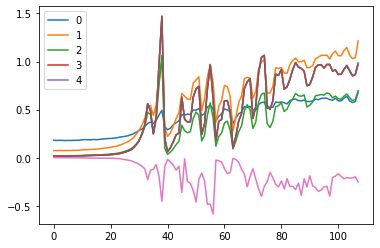

In [35]:
for o in act_means:
    plt.plot(o)
plt.legend(range(5))

### Hook Class

In [36]:
from dltools.hook import Hook, children, append_stats

In [37]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

self.device: cuda


In [38]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [39]:
run.fit(1, learn)

train: [2.27901921875, tensor(0.1616, device='cuda:0')]
valid: [2.256306640625, tensor(0.1908, device='cuda:0')]


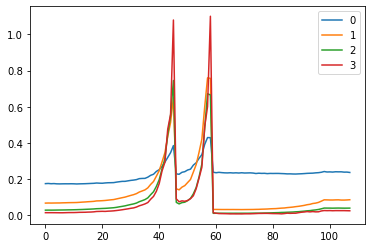

In [40]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4))

In [41]:
from dltools.hook import ListContainer

In [42]:
t = ListContainer(range(10))

In [44]:
from torch.nn import init
from dltools.hook import Hooks

In [47]:
model = get_cnn_model(data, nfs).cuda()

In [49]:
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

self.device: cuda


In [52]:
hooks = Hooks(model, append_stats)

In [53]:
hooks

Hooks (7 items
[<dltools.hook.Hook object at 0x000001FCEFFDFCF8>, <dltools.hook.Hook object at 0x000001FCEFFDFF98>, <dltools.hook.Hook object at 0x000001FCEFFC3048>, <dltools.hook.Hook object at 0x000001FCEFFC3198>, <dltools.hook.Hook object at 0x000001FCEFFC30B8>, <dltools.hook.Hook object at 0x000001FCEFFC3630>, <dltools.hook.Hook object at 0x000001FCEFFC3710>]

In [54]:
hooks.remove()

In [56]:
x, y = next(iter(data.train_dl))

In [57]:
x = mnist_resize(x).cuda()

In [58]:
x.mean(), x.std()

(tensor(-0.0023, device='cuda:0'), tensor(0.9978, device='cuda:0'))

In [60]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.2090, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.4016, device='cuda:0', grad_fn=<StdBackward0>))

In [63]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [64]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.3627, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.7276, device='cuda:0', grad_fn=<StdBackward0>))

train: [0.16218630859375, tensor(0.9500, device='cuda:0')]
valid: [0.14770635986328126, tensor(0.9547, device='cuda:0')]
train: [0.112900546875, tensor(0.9650, device='cuda:0')]
valid: [0.16266207275390626, tensor(0.9512, device='cuda:0')]


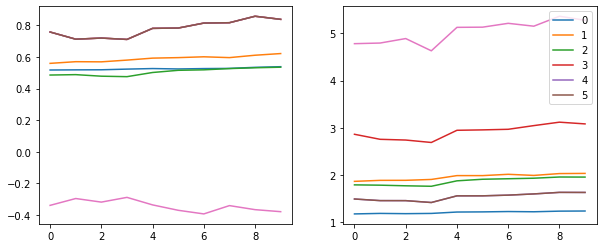

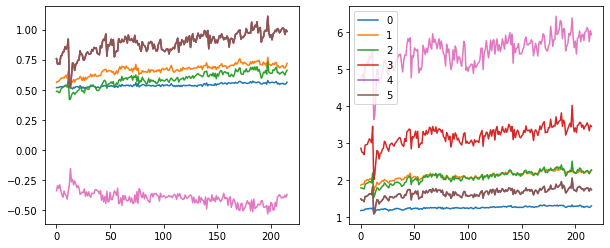

In [66]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms, ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6))
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (10, 4))
    
    for h in hooks:
        ms, ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6))

### Other statistics

In [67]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'):
        hook.stats = ([], [], [])
    means, stds, hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds.append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40, 0, 10)) # histc not implemented on GPU

In [68]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

self.device: cuda


In [69]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [70]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)

train: [2.1759721875, tensor(0.2422, device='cuda:0')]
valid: [1.19445205078125, tensor(0.5397, device='cuda:0')]


In [72]:
def get_hist(h):
    return torch.stack(h.stats[2]).t().float().log1p()

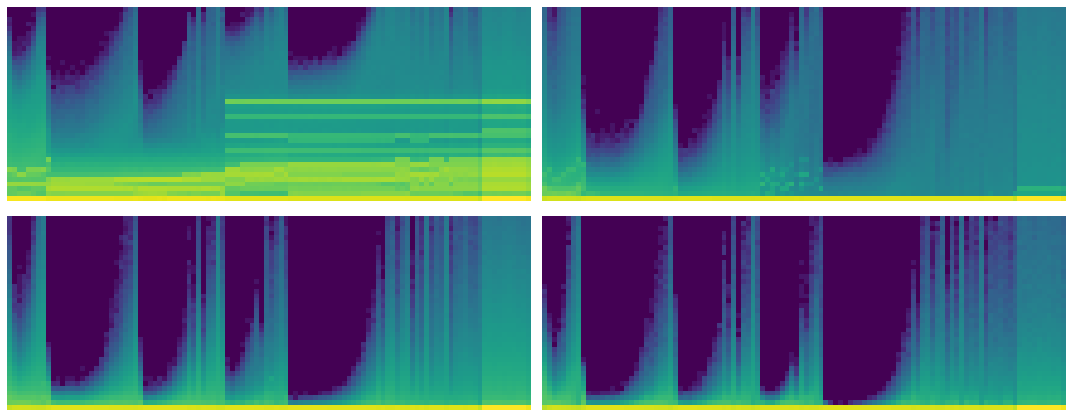

In [73]:
fig, axes = plt.subplots(2, 2, figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
    plt.tight_layout()

In [77]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0)

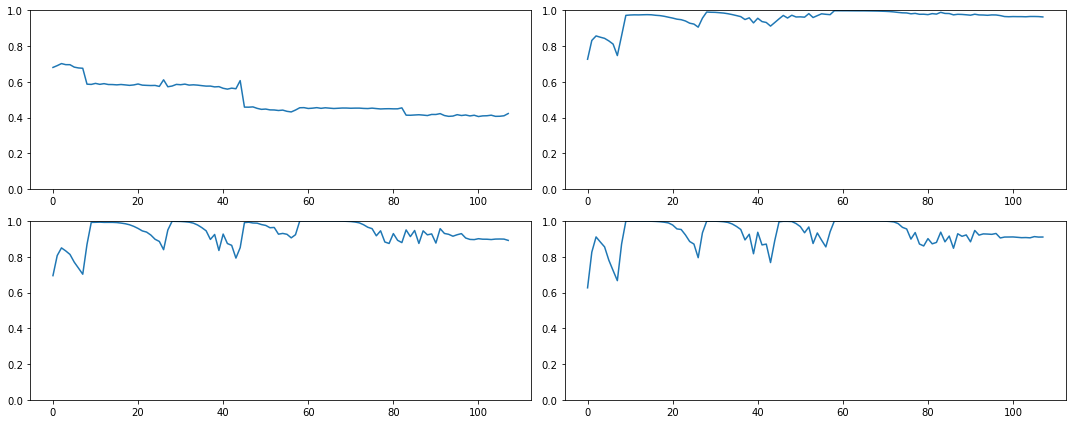

In [78]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0, 1)
plt.tight_layout()

## Generalized ReLU

In [98]:
from dltools.functions import get_cnn_layers, init_cnn, get_cnn_model
from dltools.layer import conv_layer, GeneralRelu

In [100]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'):
        hook.stats = ([], [], [])
    means, stds, hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds.append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40, -7, 7))        

In [95]:
model = get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

self.device: cuda


train: [0.547208125, tensor(0.8257, device='cuda:0')]
valid: [0.17524908447265625, tensor(0.9448, device='cuda:0')]


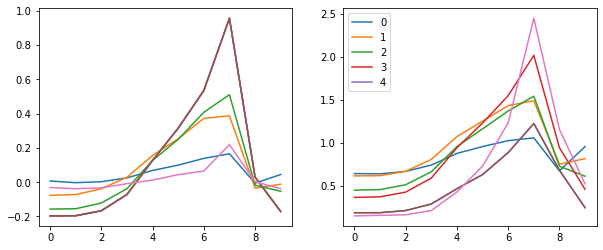

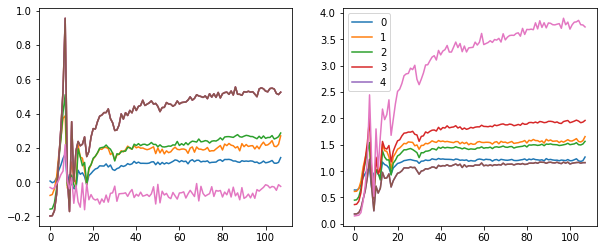

In [101]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms, ss, hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5))
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms, ss, hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5))

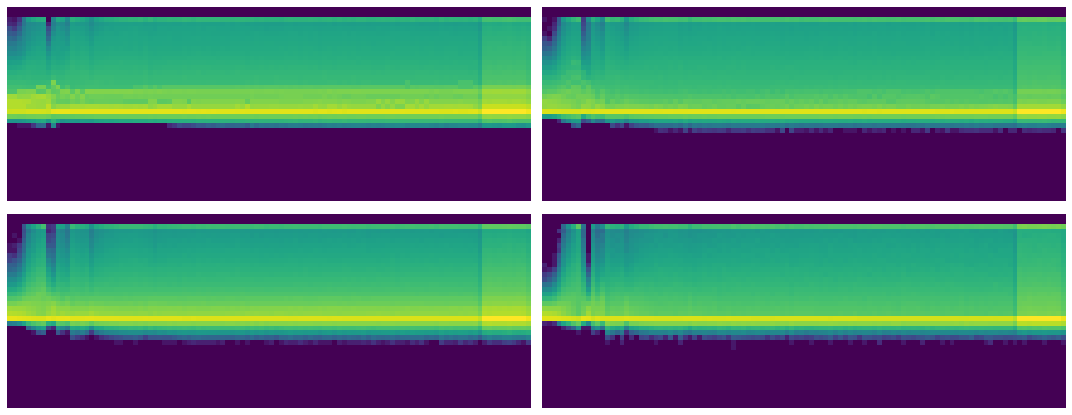

In [102]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [106]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

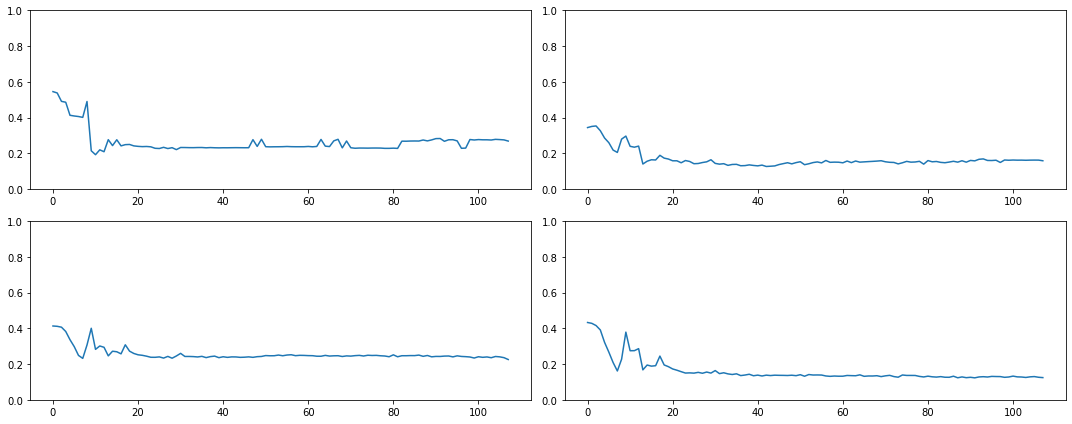

In [107]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [110]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)])

In [112]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler, 'lr', sched)])

self.device: cuda


In [114]:
run.fit(8, learn)

train: [1.067902421875, tensor(0.6630, device='cuda:0')]
valid: [0.294240478515625, tensor(0.9112, device='cuda:0')]
train: [0.31930814453125, tensor(0.9021, device='cuda:0')]
valid: [0.190110107421875, tensor(0.9437, device='cuda:0')]
train: [0.2245453515625, tensor(0.9334, device='cuda:0')]
valid: [0.17426490478515624, tensor(0.9491, device='cuda:0')]
train: [0.143540869140625, tensor(0.9572, device='cuda:0')]
valid: [0.09514343872070312, tensor(0.9722, device='cuda:0')]
train: [0.082268603515625, tensor(0.9746, device='cuda:0')]
valid: [0.07678912963867188, tensor(0.9769, device='cuda:0')]
train: [0.055244482421875, tensor(0.9833, device='cuda:0')]
valid: [0.06649371337890625, tensor(0.9811, device='cuda:0')]
train: [0.04144455078125, tensor(0.9871, device='cuda:0')]
valid: [0.05973114013671875, tensor(0.9835, device='cuda:0')]
train: [0.03384286865234375, tensor(0.9894, device='cuda:0')]
valid: [0.059533770751953125, tensor(0.9839, device='cuda:0')]
